<a href="https://colab.research.google.com/github/VishalIITB/Colab-Neural-Network-and-Deep-Learning-By-Michael-Nielsen/blob/main/Neural_Network_and_Deep_Learning_By_Michael_Nielsen24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf

# Load MNIST dataset directly from TensorFlow/Keras
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the images
train_images = train_images.reshape(train_images.shape[0], 784, 1) / 255.0
test_images = test_images.reshape(test_images.shape[0], 784, 1) / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position and zeroes elsewhere."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# Convert labels into one-hot encoded format
train_data = [(x, vectorized_result(y)) for x, y in zip(train_images, train_labels)]
test_data = [(x, y) for x, y in zip(test_images, test_labels)]


In [ ]:
# Initialize the network
net = Network([784, 30, 10])

# Train the network using Stochastic Gradient Descent (SGD)
net.SGD(train_data, epochs=30, mini_batch_size=10, eta=3.0, test_data=test_data)


Epoch 0: 7379 / 10000
Epoch 1: 8206 / 10000
Epoch 2: 8431 / 10000
Epoch 3: 8471 / 10000
Epoch 4: 8496 / 10000
Epoch 5: 8526 / 10000
Epoch 6: 8485 / 10000
Epoch 7: 8556 / 10000
Epoch 8: 8549 / 10000
Epoch 9: 8566 / 10000
Epoch 10: 8564 / 10000
Epoch 11: 8570 / 10000
Epoch 12: 8590 / 10000
Epoch 13: 8582 / 10000
Epoch 14: 8592 / 10000
Epoch 15: 8563 / 10000
Epoch 16: 8594 / 10000
Epoch 17: 8615 / 10000
Epoch 18: 8604 / 10000
Epoch 19: 8611 / 10000
Epoch 20: 8593 / 10000
Epoch 21: 8594 / 10000
Epoch 22: 8603 / 10000
Epoch 23: 8618 / 10000
Epoch 24: 8606 / 10000
Epoch 25: 8630 / 10000
Epoch 26: 8609 / 10000
Epoch 27: 8608 / 10000
Epoch 28: 8595 / 10000
Epoch 29: 8600 / 10000


In [ ]:
class Network:

    def __init__(self, sizes):
        # Initialize network architecture: layers sizes
        self.num_layers = len(sizes)
        self.sizes = sizes
        # Initialize biases and weights for hidden and output layers
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def feedforward(self, a):
        """Return the output of the network for input 'a'."""
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """Train the network using mini-batch stochastic gradient descent."""
        training_data = list(training_data)
        n = len(training_data)

        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)

            if test_data:
                accuracy = self.evaluate(test_data)
                print(f"Epoch {epoch}: {accuracy} / {len(test_data)}")
            else:
                print(f"Epoch {epoch} complete")

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases using backpropagation for each mini-batch."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        self.weights = [w - (eta / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return the gradient of the cost function with respect to the weights and biases."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Feedforward
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        # Backward pass
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs correctly classified by the network."""
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the derivative of the cost function with respect to the output activations."""
        return (output_activations - y)


In [ ]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position and zeroes elsewhere."""
    e = np.zeros((10, 1))
    e[int(j)] = 1.0  # Ensure 'j' is treated as an integer
    return e

# Prepare training and test data
training_data = [(x.reshape(784, 1), vectorized_result(y)) for x, y in zip(train_images, train_labels)]
test_data = [(x.reshape(784, 1), y) for x, y in zip(test_images, test_labels)]


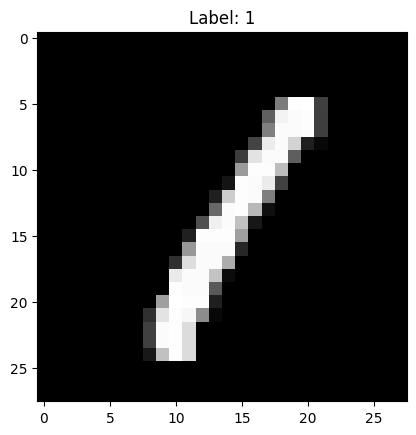

In [ ]:
import matplotlib.pyplot as plt

# Pick a sample image from the training data
sample_image = train_images[3]
sample_label = train_labels[3]

# Reshape it back to 28x28 for viewing
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title(f"Label: {sample_label}")
plt.show()


In [ ]:
# Print one-hot encoded vector for a sample label
print("Original label:", sample_label)
print("One-hot encoded vector:", vectorized_result(sample_label))


Original label: 1
One-hot encoded vector: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# Train on a small sample of 100 images
small_training_data = training_data[:100]
net.SGD(small_training_data, epochs=1, mini_batch_size=10, eta=3.0, test_data=test_data[:10])


Epoch 0: 8 / 10
